In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
import h5py
from scripts.sample_db import SampleDB

def compute_correlation_matrix(traces, window_size):
    num_traces, trace_length = traces.shape
    num_windows = trace_length - window_size + 1
    correlation_matrix = np.zeros((num_traces, num_traces))
    
    for i in range(num_traces):
        for j in range(i, num_traces):
            correlations = []
            for k in range(num_windows):
                window_i = traces[i, k:k+window_size]
                window_j = traces[j, k:k+window_size]
                corr, _ = pearsonr(window_i, window_j)
                correlations.append(corr)
            
            avg_correlation = np.mean(correlations)
            correlation_matrix[i, j] = avg_correlation
            correlation_matrix[j, i] = avg_correlation
    
    return correlation_matrix

def plot_correlation_matrix(correlation_matrix, odors, trials, title):
    plt.figure(figsize=(12, 10))
    sns.heatmap(correlation_matrix, cmap='coolwarm', vmin=-1, vmax=1, center=0,
                square=True, annot=False, cbar=True)
    
    # Add odor and trial labels
    ax = plt.gca()
    ax.set_xticks(np.arange(len(odors)) + 0.5)
    ax.set_yticks(np.arange(len(odors)) + 0.5)
    ax.set_xticklabels([f'Odor {o}\nTrial {t}' for o, t in zip(odors, trials)], rotation=45, ha='right')
    ax.set_yticklabels([f'Odor {o}\nTrial {t}' for o, t in zip(odors, trials)], rotation=0)
    
    plt.title(title)
    plt.tight_layout()
    plt.show()

# Main script
if __name__ == "__main__":
    # Load the sample database
    db_path = r'\\tungsten-nas.fmi.ch\tungsten\scratch\gfriedri\montruth\sample_db.csv'
    sample_db = SampleDB()
    sample_db.load(db_path)

    # Loading experiment
    sample_id = '20220426_RM0008_130hpf_fP1_f3'  
    exp = sample_db.get_sample(sample_id)
    print(exp.sample.id)

20220426_RM0008_130hpf_fP1_f3


In [4]:

    # Path to the HDF5 file
    hdf5_file_path = f'{exp.paths.trials_path}/traces/{exp.sample.id}_fluorescence_data.h5'

    # Load data from HDF5 file
    with h5py.File(hdf5_file_path, 'r') as f:
        exp_grp = f[exp.sample.id]
        print(exp_grp.keys())
        traces = exp_grp['dff_traces'][()]  # Use dF/F traces
        odors = exp_grp['odor'][()]
        trials = exp_grp['trial_nr'][()]

<KeysViewHDF5 ['cell_mapping', 'dff_traces', 'lm_plane_centroids', 'lm_plane_labels', 'odor', 'plane_nr', 'raw_traces', 'trial_nr']>


In [11]:

    # Sort traces by odor and trial
    sort_indices = np.lexsort((trials, odors))
    print(sort_indices)
    traces = traces[sort_indices]
    print(traces[:10])
    odors = odors[sort_indices]
    print(odors[:10])
    trials = trials[sort_indices]
    print(trials[:10])

[    0     1     2 ... 52628 52629 52630]
[[ 1.1610324e-03 -1.3413973e-03 -1.3914388e-03 ...  9.2846580e-04
   9.7496714e-04  1.1619324e-03]
 [-1.1013461e-04 -1.5393052e-03 -1.6417017e-03 ...  5.9080386e-04
   1.5879540e-03  6.7064544e-04]
 [ 1.3008186e-03 -1.3075984e-03 -1.4139751e-03 ...  1.5041522e-04
  -3.2542966e-04  9.8456876e-05]
 ...
 [ 4.4400729e-03 -1.1137534e-03 -1.4093822e-03 ... -8.3402498e-05
   1.5630468e-04  3.2046961e-04]
 [-4.4218841e-04 -1.8254891e-03 -1.8342453e-03 ...  2.5488957e-04
   7.4349786e-04  6.3104660e-04]
 [-2.4680898e-04 -1.2737695e-03 -1.2737695e-03 ...  9.2170820e-05
  -3.5248138e-04 -2.1362508e-05]]
[b'Ala' b'Ala' b'Ala' b'Ala' b'Ala' b'Ala' b'Ala' b'Ala' b'Ala' b'Ala']
[b'1' b'1' b'1' b'1' b'1' b'1' b'1' b'1' b'1' b'1']


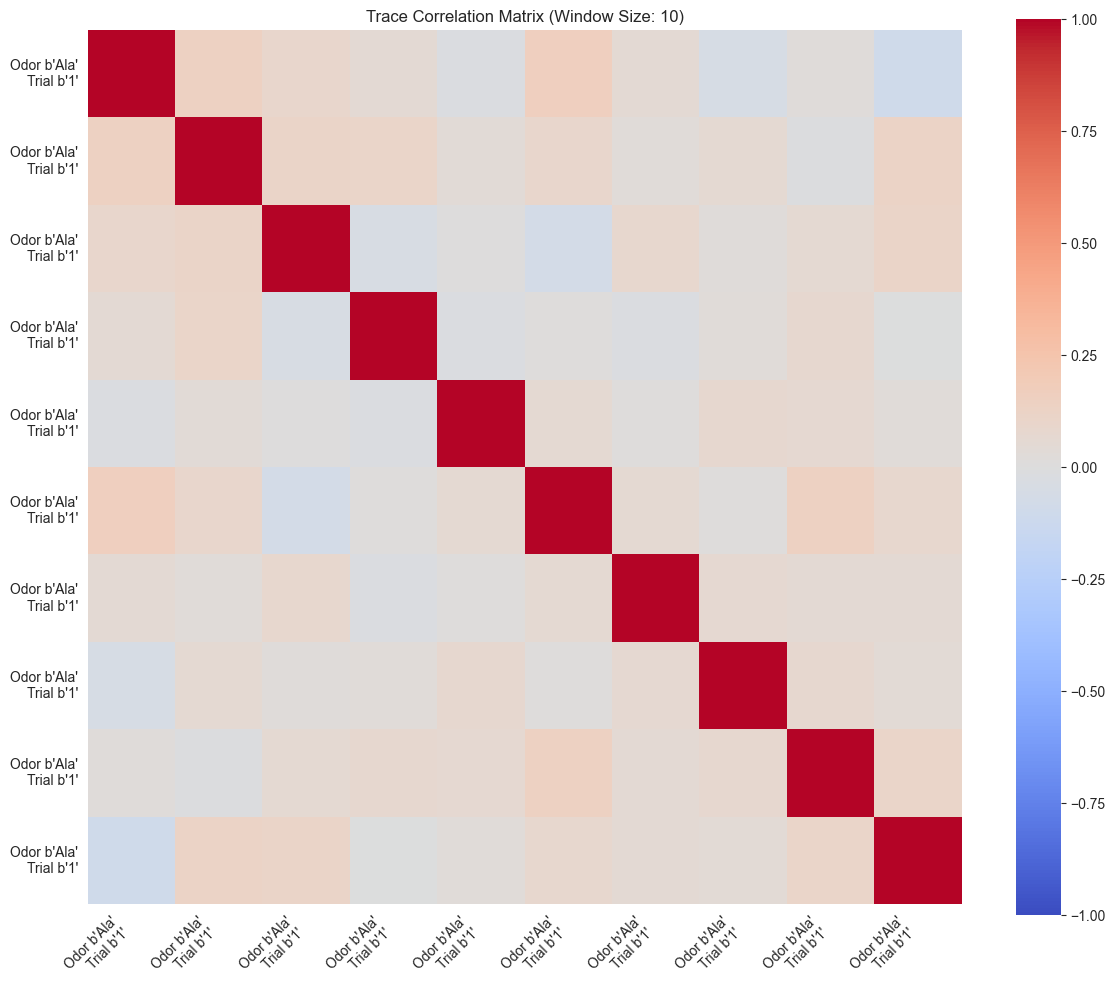

In [12]:

    # User input for window size
    window_size = int(input("Enter the window size (frames) for correlation calculation: "))

    # Compute correlation matrix
    correlation_matrix = compute_correlation_matrix(traces[:10], window_size)

    # Plot correlation matrix
    plot_correlation_matrix(correlation_matrix, odors[:10], trials[:10], f"Trace Correlation Matrix (Window Size: {window_size})")

20220426_RM0008_130hpf_fP1_f3
<KeysViewHDF5 ['cell_mapping', 'dff_traces', 'lm_plane_centroids', 'lm_plane_labels', 'odor', 'plane_nr', 'raw_traces', 'trial_nr']>


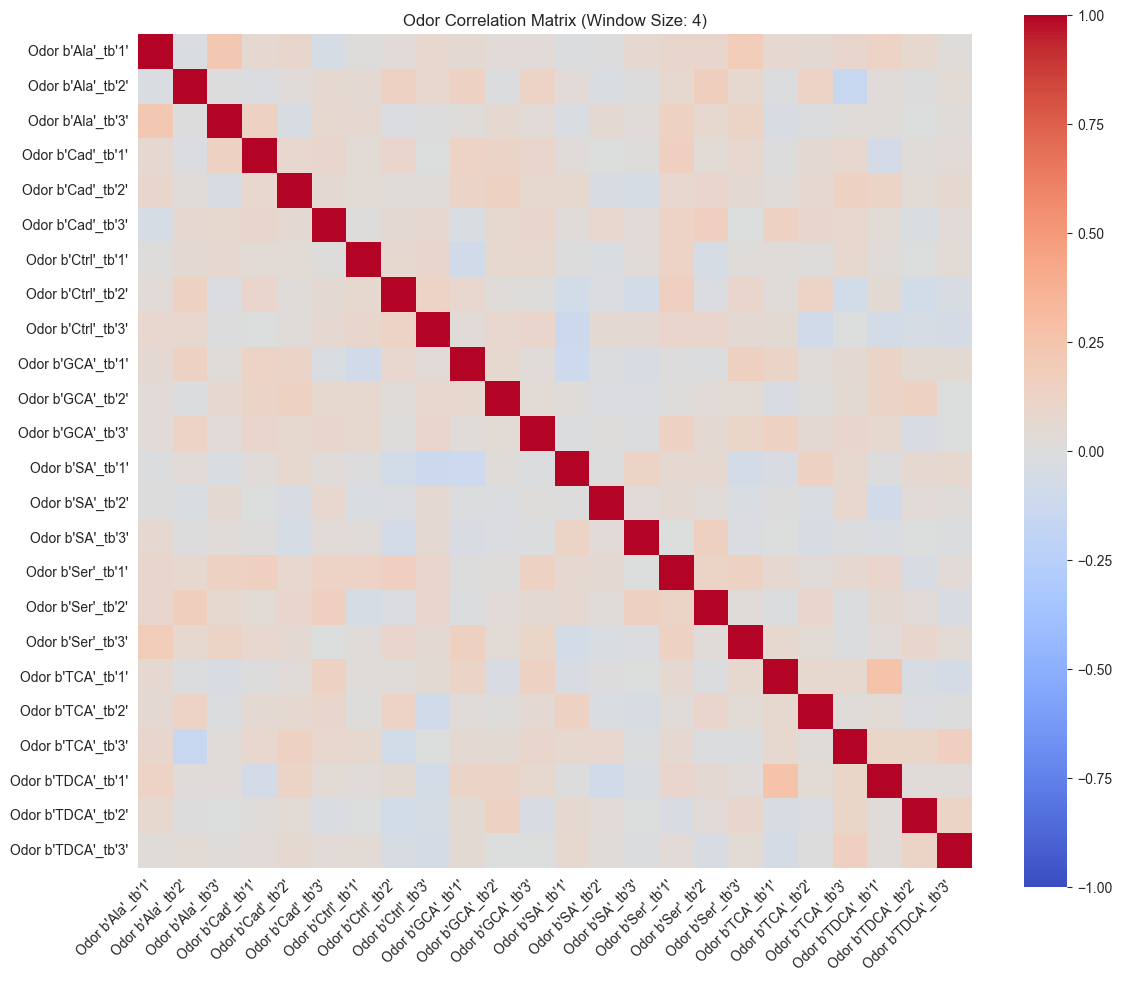

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
import h5py
from scripts.sample_db import SampleDB

import h5py
import numpy as np

def average_traces(traces, odors, trials, average_by='odor_trial'):
    unique_combinations = []
    averaged_traces = []
    averaged_labels = []
    
    if average_by == 'odor':
        unique_combinations = np.unique(odors)
    elif average_by == 'trial':
        unique_combinations = np.unique(trials)
    elif average_by == 'odor_trial':
        unique_combinations = np.unique(list(zip(odors, trials)), axis=0)
    else:
        raise ValueError("average_by must be 'odor', 'trial', or 'odor_trial'")
    
    for combo in unique_combinations:
        if average_by == 'odor':
            mask = odors == combo
            label = f"{combo}"
        elif average_by == 'trial':
            mask = trials == combo
            label = f"t{combo}"
        else:  # odor_trial
            odor, trial = combo
            mask = (odors == odor) & (trials == trial)
            label = f"{odor}_t{trial}"
        
        avg_trace = np.mean(traces[mask], axis=0)
        averaged_traces.append(avg_trace)
        averaged_labels.append(label)
    
    return np.array(averaged_traces), np.array(averaged_labels)

def compute_correlation_matrix(traces, window_size):
    num_traces, trace_length = traces.shape
    num_windows = trace_length - window_size + 1
    correlation_matrix = np.zeros((num_traces, num_traces))
    
    for i in range(num_traces):
        for j in range(i, num_traces):
            correlations = []
            for k in range(num_windows):
                window_i = traces[i, k:k+window_size]
                window_j = traces[j, k:k+window_size]
                corr, _ = pearsonr(window_i, window_j)
                correlations.append(corr)
            
            avg_correlation = np.mean(correlations)
            correlation_matrix[i, j] = avg_correlation
            correlation_matrix[j, i] = avg_correlation
    
    return correlation_matrix

def plot_correlation_matrix(correlation_matrix, odors, title):
    plt.figure(figsize=(12, 10))
    sns.heatmap(correlation_matrix, cmap='coolwarm', vmin=-1, vmax=1, center=0,
                square=True, annot=False, cbar=True)
    
    # Add odor labels
    ax = plt.gca()
    ax.set_xticks(np.arange(len(odors)) + 0.5)
    ax.set_yticks(np.arange(len(odors)) + 0.5)
    ax.set_xticklabels([f'Odor {o}' for o in odors], rotation=45, ha='right')
    ax.set_yticklabels([f'Odor {o}' for o in odors], rotation=0)
    
    plt.title(title)
    plt.tight_layout()
    plt.show()

# Main script
if __name__ == "__main__":
    # Load the sample database
    db_path = r'\\tungsten-nas.fmi.ch\tungsten\scratch\gfriedri\montruth\sample_db.csv'
    sample_db = SampleDB()
    sample_db.load(db_path)

    # Loading experiment
    sample_id = '20220426_RM0008_130hpf_fP1_f3'  
    exp = sample_db.get_sample(sample_id)
    print(exp.sample.id)

    # Path to the HDF5 file
    hdf5_file_path = f'{exp.paths.trials_path}/traces/{exp.sample.id}_fluorescence_data.h5'

    # Load data from HDF5 file
    with h5py.File(hdf5_file_path, 'r') as f:
        exp_grp = f[exp.sample.id]
        print(exp_grp.keys())
        traces = exp_grp['dff_traces'][()]  # Use dF/F traces
        odors = exp_grp['odor'][()]
        trials = exp_grp['trial_nr'][()]

    # Average traces over trials for each odor
    averaged_traces, averaged_odors = average_traces(traces, odors, trials)

    # User input for window size
    window_size = int(input("Enter the window size for correlation calculation: "))

    # Compute correlation matrix
    correlation_matrix = compute_correlation_matrix(averaged_traces, window_size)

    # Plot correlation matrix
    plot_correlation_matrix(correlation_matrix, averaged_odors, f"Odor Correlation Matrix (Window Size: {window_size})")

In [2]:
# 13_analyze_and_visualize_correlation_lm_traces.py

import os
import sys
import argparse
import logging
from datetime import datetime
import h5py
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import seaborn as sns
import napari

#sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath(__file__))))

from scripts.sample_db import SampleDB
from scripts.utils.traces_utils import load_hdf5_data

STEP_NAME = '13_analyze_correlation_lm_traces'

def setup_logging(script_name):
    log_folder = r'\\tungsten-nas.fmi.ch\tungsten\scratch\gfriedri\montruth\2P_RawData\log'
    os.makedirs(log_folder, exist_ok=True)
    current_date = datetime.now().strftime('%Y%m%d')
    log_file = f"{current_date}_{script_name}.log"
    log_path = os.path.join(log_folder, log_file)
    logging.basicConfig(filename=log_path, level=logging.ERROR,
                        format='%(asctime)s - %(levelname)s - %(message)s')

def average_traces(traces, odors, trials, average_by='odor_trial'):
    unique_combinations = []
    averaged_traces = []
    averaged_labels = []
    
    if average_by == 'odor':
        unique_combinations = np.unique(odors)
    elif average_by == 'trial':
        unique_combinations = np.unique(trials)
    elif average_by == 'odor_trial':
        unique_combinations = np.unique(list(zip(odors, trials)), axis=0)
    else:
        raise ValueError("average_by must be 'odor', 'trial', or 'odor_trial'")
    
    for combo in unique_combinations:
        if average_by == 'odor':
            mask = odors == combo
            label = f"{combo}"
        elif average_by == 'trial':
            mask = trials == combo
            label = f"t{combo}"
        else:  # odor_trial
            odor, trial = combo
            mask = (odors == odor) & (trials == trial)
            label = f"{odor}_t{trial}"
        
        avg_trace = np.mean(traces[mask], axis=0)
        averaged_traces.append(avg_trace)
        averaged_labels.append(label)
    
    return np.array(averaged_traces), np.array(averaged_labels)

def compute_correlation_matrices(traces, window_size=4):
    num_traces, trace_length = traces.shape
    num_windows = trace_length - window_size + 1
    correlation_matrices = np.zeros((num_windows, num_traces, num_traces))
    
    for k in range(num_windows):
        window_traces = traces[:, k:k+window_size]
        for i in range(num_traces):
            for j in range(i, num_traces):
                corr, _ = pearsonr(window_traces[i], window_traces[j])
                correlation_matrices[k, i, j] = corr
                correlation_matrices[k, j, i] = corr
    
    return correlation_matrices

def plot_correlation_matrix(correlation_matrix, labels, title, save_path):
    plt.figure(figsize=(12, 10))
    sns.heatmap(correlation_matrix, cmap='coolwarm', vmin=-1, vmax=1, center=0,
                square=True, annot=False, cbar=True)
    
    ax = plt.gca()
    ax.set_xticks(np.arange(len(labels)) + 0.5)
    ax.set_yticks(np.arange(len(labels)) + 0.5)
    ax.set_xticklabels(labels, rotation=90, ha='right')
    ax.set_yticklabels(labels, rotation=0)
    
    plt.title(title)
    plt.tight_layout()
    plt.savefig(save_path)
    plt.close()

def visualize_correlation_matrices(correlation_matrices, averaged_labels):
    viewer = napari.Viewer()
    viewer.add_image(correlation_matrices, name='Correlation Matrices', colormap='coolwarm', contrast_limits=(-1, 1))
    
    text_params = {
        'text': averaged_labels,
        'size': 8,
        'color': 'white',
        'anchor': 'center',
        'translation': [0, 0, 0],
    }
    viewer.add_points(np.array([[i, j, 0] for i in range(len(averaged_labels)) for j in range(len(averaged_labels))]),
                      text=text_params,
                      name='Labels',
                      size=0,
                      opacity=0)
    napari.run()


In [4]:

sample_id = '20220426_RM0008_130hpf_fP1_f3'
db_path = r'\\tungsten-nas.fmi.ch\tungsten\scratch\gfriedri\montruth\sample_db.csv'

In [5]:

# Step 1: Load the sample database
sample_db = SampleDB()
sample_db.load(db_path)

In [7]:

# Step 2: Load experiment configuration
exp = sample_db.get_sample(sample_id)

# Step 3: Check if this step has already been completed
if sample_db.samples[sample_id].get(STEP_NAME) == "True":
    print(f"{STEP_NAME} already completed for sample {sample_id}. Skipping.")

In [8]:

# Step 4: Load data
traces_folder = os.path.join(exp.paths.trials_path, "traces")
hdf5_file_path = os.path.join(traces_folder, f'{exp.sample.id}_fluorescence_data.h5')
data = load_hdf5_data(hdf5_file_path, exp.sample.id)

In [9]:

# Step 5: Average traces
averaged_traces, averaged_labels = average_traces(data['dff_traces'], data['odor'], data['trial_nr'])

In [16]:
# Convert averaged_labels to ASCII
averaged_labels_ascii = np.array([label.encode('ascii', 'ignore') for label in averaged_labels])


In [17]:
averaged_labels

array(["b'Ala'_tb'1'", "b'Ala'_tb'2'", "b'Ala'_tb'3'", "b'Cad'_tb'1'",
       "b'Cad'_tb'2'", "b'Cad'_tb'3'", "b'Ctrl'_tb'1'", "b'Ctrl'_tb'2'",
       "b'Ctrl'_tb'3'", "b'GCA'_tb'1'", "b'GCA'_tb'2'", "b'GCA'_tb'3'",
       "b'SA'_tb'1'", "b'SA'_tb'2'", "b'SA'_tb'3'", "b'Ser'_tb'1'",
       "b'Ser'_tb'2'", "b'Ser'_tb'3'", "b'TCA'_tb'1'", "b'TCA'_tb'2'",
       "b'TCA'_tb'3'", "b'TDCA'_tb'1'", "b'TDCA'_tb'2'", "b'TDCA'_tb'3'"],
      dtype='<U13')

In [18]:
averaged_labels_ascii

array([b"b'Ala'_tb'1'", b"b'Ala'_tb'2'", b"b'Ala'_tb'3'", b"b'Cad'_tb'1'",
       b"b'Cad'_tb'2'", b"b'Cad'_tb'3'", b"b'Ctrl'_tb'1'",
       b"b'Ctrl'_tb'2'", b"b'Ctrl'_tb'3'", b"b'GCA'_tb'1'",
       b"b'GCA'_tb'2'", b"b'GCA'_tb'3'", b"b'SA'_tb'1'", b"b'SA'_tb'2'",
       b"b'SA'_tb'3'", b"b'Ser'_tb'1'", b"b'Ser'_tb'2'", b"b'Ser'_tb'3'",
       b"b'TCA'_tb'1'", b"b'TCA'_tb'2'", b"b'TCA'_tb'3'",
       b"b'TDCA'_tb'1'", b"b'TDCA'_tb'2'", b"b'TDCA'_tb'3'"], dtype='|S13')

In [11]:

# Step 6: Compute correlation matrices
correlation_matrices = compute_correlation_matrices(averaged_traces)

In [12]:
correlation_matrices.shape

(372, 24, 24)

In [23]:
viewer = napari.Viewer()
viewer.add_image(correlation_matrices, name='Correlation Matrices', contrast_limits=(-1, 1))

# Create a grid of points for each label
n_labels = len(averaged_labels)
y, x = np.mgrid[0:n_labels, 0:n_labels]
points = np.column_stack((x.ravel(), y.ravel(), np.zeros(n_labels**2)))

# Create text parameters
text_params = {
    'text': averaged_labels_ascii,
    'size': 8,
    'color': 'white',
    'anchor': 'center',
    'translation': [-0.5, -0.5, 0],  # Adjust to center text on grid
}

# Add points layer with text
viewer.add_points(
    points,
    size=0,  # Make points invisible
    name='Labels',
    text=text_params,
    opacity=0,  # Make points transparent
)

D:\montruth\PycharmProjects\samplePy\.venv\lib\site-packages\napari\plugins\_plugin_manager.py:555: UserWarning: Plugin 'napari-animated-gif-io' has already registered a function widget 'save as animated gif' which has now been overwritten
  warn(message=warn_message)


ValidationError: 1 validation error for TextManager
string
  value should be a StringEncoding, a dict, a string, a sequence of strings, or None (type=type_error)

In [26]:
exp.params_odor


ParamsOdor(odor_list=['Ala', 'Ser', 'Ctrl', 'TCA', 'GCA', 'TDCA', 'Cad', 'SA'], odor_sequence=['Ala', 'Ser', 'Ctrl', 'TCA', 'GCA', 'TDCA', 'Cad', 'SA', 'Cad', 'TDCA', 'GCA', 'TCA', 'Ser', 'Ctrl', 'Ala', 'SA', 'Ctrl', 'Cad', 'Ala', 'Ser', 'TDCA', 'GCA', 'TCA', 'SA'], odor_concentration_uM=[OdorConcentration(name='Ala', concentration_mM=100.0), OdorConcentration(name='Ser', concentration_mM=100.0), OdorConcentration(name='Ctrl', concentration_mM=100.0), OdorConcentration(name='TCA', concentration_mM=10.0), OdorConcentration(name='GCA', concentration_mM=10.0), OdorConcentration(name='TDCA', concentration_mM=10.0), OdorConcentration(name='Cad', concentration_mM=300.0), OdorConcentration(name='SA', concentration_mM=0.0)], n_trials=3, pulse_delay_s=15, trial_interval_s=60, missed_trials=[], events=[], pulse_duration_s=5)

In [ ]:
# Step 7: Create report folder
report_folder = os.path.join(exp.paths.root_path, "report")
os.makedirs(report_folder, exist_ok=True)

# Step 8: Plot and save correlation matrices
for i, matrix in enumerate([correlation_matrices[0], correlation_matrices[len(correlation_matrices)//2], correlation_matrices[-1]]):
    plot_correlation_matrix(matrix, averaged_labels,
                            f"Correlation Matrix - Window {i} - {exp.sample.id}",
                            os.path.join(report_folder, f'{STEP_NAME}_window_{i}_{exp.sample.id}.png'))

In [19]:

# Step 9: Save correlation matrices to HDF5 file
with h5py.File(hdf5_file_path, 'r+') as f:
    exp_grp = f[sample_id]
    if 'correlation_matrices' in exp_grp:
        del exp_grp['correlation_matrices']
    exp_grp.create_dataset('correlation_matrices', data=correlation_matrices)
    exp_grp.create_dataset('averaged_labels', data=averaged_labels_ascii)

print("Correlation matrices calculated and saved in HDF5 file.")

Correlation matrices calculated and saved in HDF5 file.


In [21]:

# Step 10: Update the sample database
sample_db.update_sample_field(sample_id, STEP_NAME, True)
sample_db.save(db_path)

print(f"Processing completed for sample: {sample_id}")

# Step 11: Visualize correlation matrices
visualize_correlation_matrices(correlation_matrices, averaged_labels)



Processing completed for sample: 20220426_RM0008_130hpf_fP1_f3


D:\montruth\PycharmProjects\samplePy\.venv\lib\site-packages\napari\plugins\_plugin_manager.py:555: UserWarning: Plugin 'napari-animated-gif-io' has already registered a function widget 'save as animated gif' which has now been overwritten
  warn(message=warn_message)


ValidationError: 1 validation error for TextManager
string
  value should be a StringEncoding, a dict, a string, a sequence of strings, or None (type=type_error)

In [27]:
import os
import sys
import h5py
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider
from scripts.sample_db import SampleDB

def load_correlation_matrices(sample_id, db_path):
    sample_db = SampleDB()
    sample_db.load(db_path)
    exp = sample_db.get_sample(sample_id)
    
    hdf5_file_path = os.path.join(exp.paths.trials_path, 'traces', f'{exp.sample.id}_fluorescence_data.h5')
    with h5py.File(hdf5_file_path, 'r') as f:
        exp_grp = f[sample_id]
        correlation_matrices = exp_grp['correlation_matrices'][()]
        averaged_labels = exp_grp['averaged_labels'][()]
    
    return correlation_matrices, averaged_labels, exp

def visualize_correlation_matrices(correlation_matrices, averaged_labels, exp):
    # Cluster the odors
    unique_odors = np.unique([label.split('_')[0] for label in averaged_labels])
    odor_order = np.argsort(unique_odors)
    sorted_indices = np.concatenate([np.where([label.startswith(odor) for label in averaged_labels])[0] for odor in unique_odors[odor_order]])
    
    # Create the main plot
    fig, ax = plt.subplots(figsize=(12, 10))
    plt.subplots_adjust(bottom=0.2)
    
    # Create the initial heatmap
    sns.heatmap(correlation_matrices[0][sorted_indices][:, sorted_indices], 
                cmap='coolwarm', vmin=-1, vmax=1, center=0, 
                xticklabels=averaged_labels[sorted_indices], 
                yticklabels=averaged_labels[sorted_indices],
                ax=ax)
    
    # Rotate x-axis labels
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    
    # Add STIM indication
    pulse_delay_s = exp.params_lm.pulse_delay_s
    pulse_duration_s = exp.params_lm.pulse_duration_s
    ax.axvline(x=pulse_delay_s, color='g', linestyle='--', label='STIM start')
    ax.axvline(x=pulse_delay_s + pulse_duration_s, color='r', linestyle='--', label='STIM end')
    ax.legend()
    
    # Add slider
    ax_slider = plt.axes([0.2, 0.05, 0.6, 0.03])
    slider = Slider(ax_slider, 'Time (s)', 0, correlation_matrices.shape[0] - 1, valinit=0, valstep=1)
    
    # Update function for slider
    def update(val):
        ax.clear()
        sns.heatmap(correlation_matrices[int(val)][sorted_indices][:, sorted_indices], 
                    cmap='coolwarm', vmin=-1, vmax=1, center=0, 
                    xticklabels=averaged_labels[sorted_indices], 
                    yticklabels=averaged_labels[sorted_indices],
                    ax=ax)
        plt.xticks(rotation=90)
        plt.yticks(rotation=0)
        ax.set_title(f'Time: {val:.2f} s')
        ax.axvline(x=pulse_delay_s, color='g', linestyle='--', label='STIM start')
        ax.axvline(x=pulse_delay_s + pulse_duration_s, color='r', linestyle='--', label='STIM end')
        ax.legend()
        fig.canvas.draw_idle()
    
    slider.on_changed(update)
    
    plt.show()


sample_id = '20220426_RM0008_130hpf_fP1_f3'
db_path = r'\\tungsten-nas.fmi.ch\tungsten\scratch\gfriedri\montruth\sample_db.csv'
correlation_matrices, averaged_labels, exp = load_correlation_matrices(sample_id, db_path)
visualize_correlation_matrices(correlation_matrices, averaged_labels, exp)


TypeError: a bytes-like object is required, not 'str'

In [ ]:
####################################################################

In [85]:
def average_traces(traces, odors, trials, average_by='odor_trial'):
    unique_combinations = []
    averaged_traces = []
    averaged_labels = []

    if average_by == 'odor':
        unique_combinations = np.unique(odors)
    elif average_by == 'trial':
        unique_combinations = np.unique(trials)
    elif average_by == 'odor_trial':
        unique_combinations = np.unique(list(zip(odors, trials)), axis=0)
    else:
        raise ValueError("average_by must be 'odor', 'trial', or 'odor_trial'")

    for combo in unique_combinations:
        if average_by == 'odor':
            mask = odors == combo
            label = f"{combo}"
        elif average_by == 'trial':
            mask = trials == combo
            label = f"t{combo}"
        else:  # odor_trial
            odor, trial = combo
            mask = (odors == odor) & (trials == trial)
            label = f"{odor}_t{trial}"

        avg_trace = np.mean(traces[mask], axis=0)
        averaged_traces.append(avg_trace)
        averaged_labels.append(label)

    return np.array(averaged_traces), np.array(averaged_labels)


def compute_correlation_matrix(window_traces):
    num_traces, _ = window_traces.shape
    correlation_matrix = np.zeros((num_traces, num_traces))
    for i in range(num_traces):
        for j in range(i, num_traces):
            corr, _ = pearsonr(window_traces[i], window_traces[j])
            correlation_matrix[i, j] = corr
            correlation_matrix[j, i] = corr
    return correlation_matrix

def compute_correlation_matrices_running_window(traces, window_size=4):
    num_traces, trace_length = traces.shape
    num_windows = trace_length - window_size + 1
    correlation_matrices = np.zeros((num_windows, num_traces, num_traces))
    
    for k in range(num_windows):
        window_traces = traces[:, k:k + window_size]
        correlation_matrices[k] = compute_correlation_matrix(window_traces)

    return correlation_matrices


def plot_correlation_matrix(correlation_matrix, labels, title, save_path, display=True):
    plt.figure(figsize=(12, 10))
    sns.heatmap(correlation_matrix, cmap='coolwarm', vmin=-1, vmax=1, center=0,
                square=True, annot=False, cbar=True)

    # Add labels
    ax = plt.gca()
    ax.set_xticks(np.arange(len(labels)) + 0.5)
    ax.set_yticks(np.arange(len(labels)) + 0.5)
    ax.set_xticklabels(labels, rotation=90, ha='right')
    ax.set_yticklabels(labels, rotation=0)

    plt.title(title)
    plt.tight_layout()
    plt.savefig(save_path)
    if display: plt.show() 
    plt.close()

db_path = r'\\tungsten-nas.fmi.ch\tungsten\scratch\gfriedri\montruth\sample_db.csv'
sample_id = '20220426_RM0008_130hpf_fP1_f3'

# Load the sample database
sample_db = SampleDB()
sample_db.load(db_path)

# Load experiment configuration
exp = sample_db.get_sample(sample_id)

print(exp.params_lm.sampling_hz)
sampling_hz_plane = exp.params_lm.sampling_hz / exp.params_lm.n_planes
print(sampling_hz_plane)
n_frames_plane = exp.params_lm.n_frames/exp.params_lm.n_planes
print(n_frames_plane)
print(n_frames_plane / sampling_hz_plane)


# Load data
traces_folder = os.path.join(exp.paths.trials_path, "traces")
hdf5_file_path = os.path.join(traces_folder, f'{exp.sample.id}_fluorescence_data.h5')
data = load_hdf5_data(hdf5_file_path, exp.sample.id)

30
7.5
375.0
50.0


In [63]:
stim_on_s = 15
stim_off_s = 15 + 5
stim_on_f = int(stim_on_s * sampling_hz_plane)
stim_off_f = int(stim_off_s * sampling_hz_plane)
print(stim_on_f, stim_off_f)
data['dff_traces'][:,stim_on_f:stim_off_f]

112 150


array([[-4.10951441e-04,  2.49966950e-04,  8.76684382e-04, ...,
         2.30562408e-03,  1.38051843e-03,  1.66312628e-03],
       [-6.44251486e-05, -5.89664087e-05,  4.63873090e-04, ...,
         2.54893256e-03,  2.59122276e-03,  1.71764416e-03],
       [ 9.69329209e-04,  5.37162938e-04,  6.39459700e-04, ...,
        -3.77987999e-06,  9.40470141e-04,  9.48689878e-04],
       ...,
       [-1.34439702e-04,  2.63831171e-05,  4.28560394e-04, ...,
        -1.09859538e-04, -1.97723130e-04, -1.06854626e-04],
       [-1.39437989e-05, -1.17801064e-05, -1.75379333e-04, ...,
         7.61499759e-05, -1.78985487e-04,  2.35001098e-05],
       [-8.94756347e-04, -5.15519467e-04, -3.15329999e-05, ...,
         1.82963477e-03,  9.51695954e-04, -9.02204134e-04]], dtype=float32)

In [77]:

# Average traces
averaged_traces, averaged_labels = average_traces(data['dff_traces'], data['odor'], data['trial_nr'])
data['dff_traces'][:, stim_on_f: stim_off_f].shape

(52631, 38)

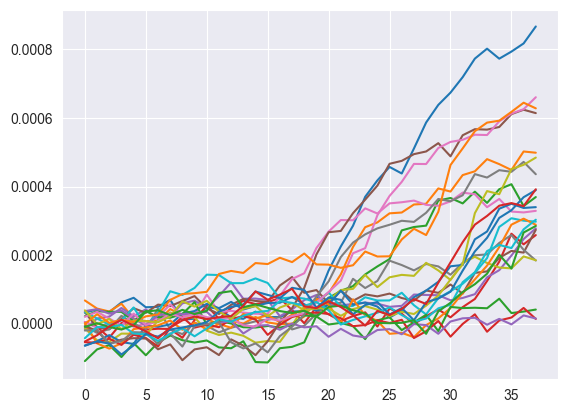

In [78]:
plt.plot(averaged_traces[:, stim_on_f: stim_off_f].T)
#plt.plot([stim_on_f, stim_off_f], [-0.0004, -0.0004], color='red', linewidth=2, label='Stimulus')

In [67]:
averaged_traces[:, stim_on_f: stim_off_s]

array([], shape=(24, 0), dtype=float32)

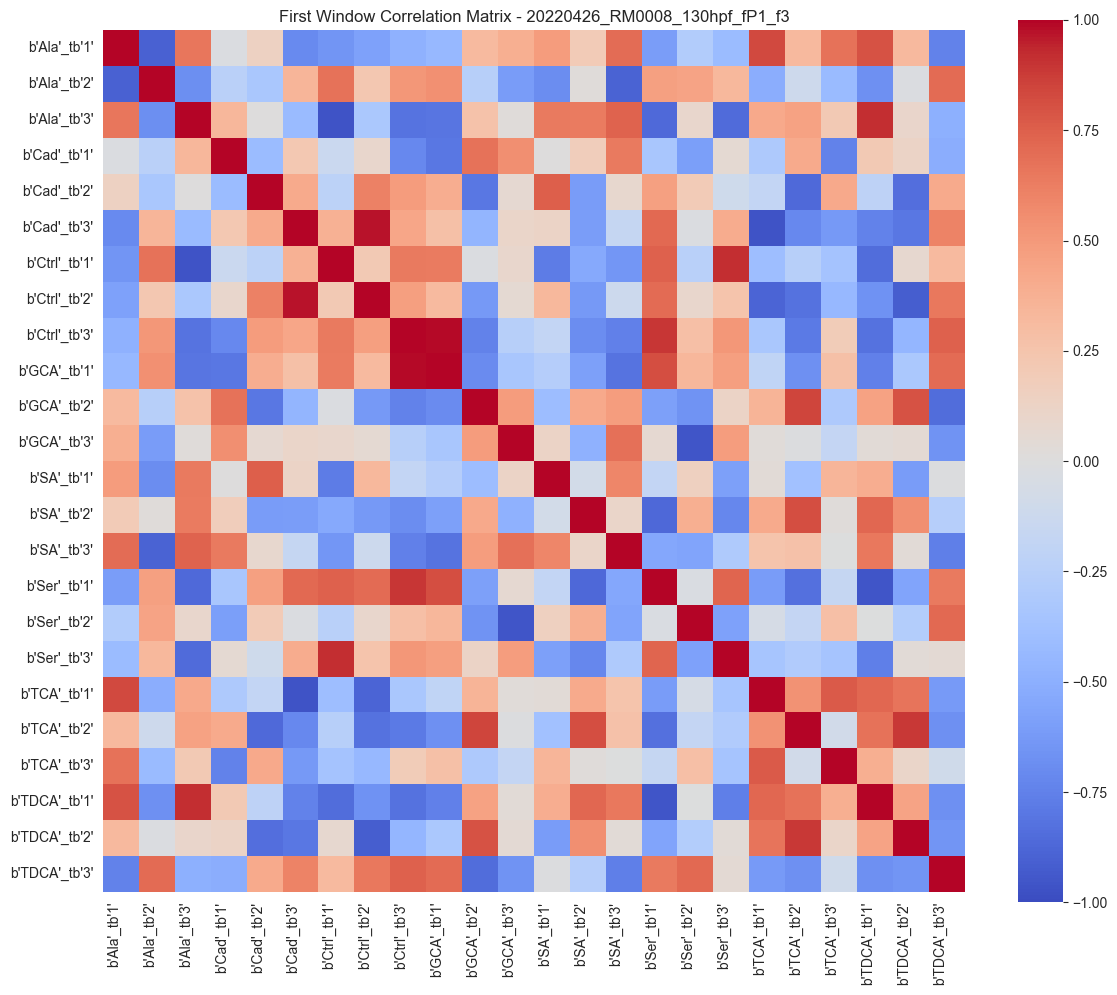

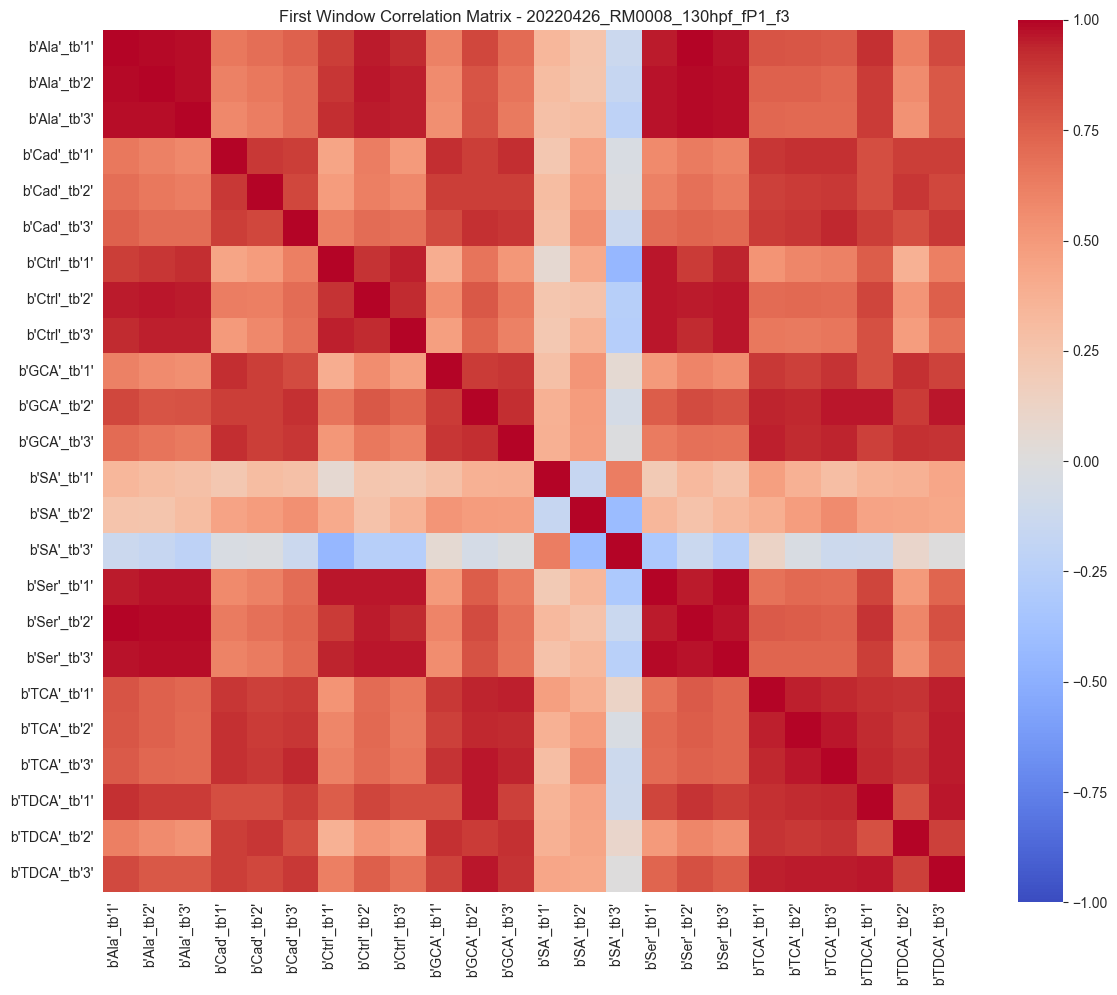

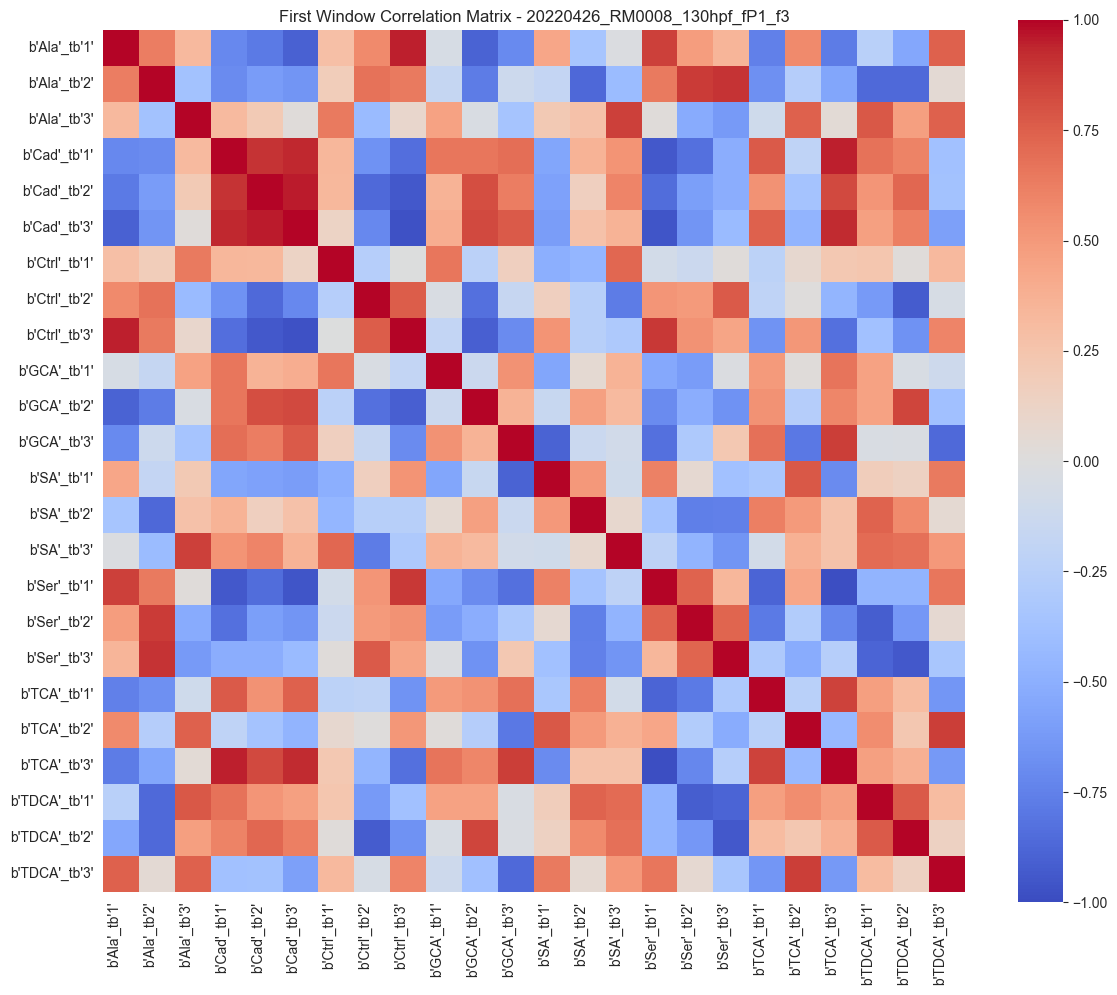

In [88]:
# Compute correlation matrices
correlation_matrix_before_stim = compute_correlation_matrix(averaged_traces[:, stim_on_f-10: stim_on_f-5])
correlation_matrix_during_stim = compute_correlation_matrix(averaged_traces[:, stim_on_f: stim_off_f])
correlation_matrix_after_stim = compute_correlation_matrix(averaged_traces[:, stim_off_f: stim_off_f+5])
plot_correlation_matrix(correlation_matrix_before_stim, averaged_labels,
                        f"First Window Correlation Matrix - {exp.sample.id}",
                        os.path.join(report_folder, f'{STEP_NAME}_first_{exp.sample.id}.png'))

plot_correlation_matrix(correlation_matrix_during_stim, averaged_labels,
                        f"First Window Correlation Matrix - {exp.sample.id}",
                        os.path.join(report_folder, f'{STEP_NAME}_first_{exp.sample.id}.png'))

plot_correlation_matrix(correlation_matrix_after_stim, averaged_labels,
                        f"First Window Correlation Matrix - {exp.sample.id}",
                        os.path.join(report_folder, f'{STEP_NAME}_first_{exp.sample.id}.png'))


In [ ]:

# Create report folder
report_folder = os.path.join(exp.paths.root_path, "report")
os.makedirs(report_folder, exist_ok=True)

for i, matrix in enumerate([correlation_matrices[0], correlation_matrices[len(correlation_matrices) // 2],
                            correlation_matrices[-1]]):
    plot_correlation_matrix(matrix, averaged_labels,
                            f"Correlation Matrix - Window {i} - {exp.sample.id}",
                            os.path.join(report_folder, f'{STEP_NAME}_window_{i}_{exp.sample.id}.png'))

# Create report folder
report_folder = os.path.join(exp.paths.root_path, "report")
os.makedirs(report_folder, exist_ok=True)

# Plot and save first, middle, and last correlation matrices
plot_correlation_matrix(correlation_matrices[0], averaged_labels,
                        f"First Window Correlation Matrix - {exp.sample.id}",
                        os.path.join(report_folder, f'{STEP_NAME}_first_{exp.sample.id}.png'))

mid_index = len(correlation_matrices) // 2
plot_correlation_matrix(correlation_matrices[mid_index], averaged_labels,
                        f"Middle Window Correlation Matrix - {exp.sample.id}",
                        os.path.join(report_folder, f'{STEP_NAME}_middle_{exp.sample.id}.png'))

plot_correlation_matrix(correlation_matrices[-1], averaged_labels,
                        f"Last Window Correlation Matrix - {exp.sample.id}",
                        os.path.join(report_folder, f'{STEP_NAME}_last_{exp.sample.id}.png'))

# Save correlation matrices to HDF5 file
with h5py.File(hdf5_file_path, 'r+') as f:
    exp_grp = f[sample_id]
    if 'correlation_matrices' in exp_grp:
        del exp_grp['correlation_matrices']
    exp_grp.create_dataset('correlation_matrices', data=correlation_matrices)
    exp_grp.create_dataset('averaged_labels', data=averaged_labels)

print("Correlation matrices calculated and saved in HDF5 file.")

# Update the sample database
sample_db.update_sample_field(sample_id, STEP_NAME, True)
sample_db.save(db_path)

print(f"Processing completed for sample: {sample_id}")